* Grab TRD loci of all crosses
* do the SNPRelate phylogeny for each locus
* extract data

In [1]:
library(data.table)
library(tidytable)
library(ggplot2)
source("~/BrusselSprouts/scripts/functions.R")


Attaching package: 'tidytable'


The following objects are masked from 'package:data.table':

    between, first, fread, last


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%



Attaching package: 'dplyr'


The following objects are masked from 'package:tidytable':

    across, add_count, add_tally, anti_join, arrange, between,
    bind_cols, bind_rows, c_across, case_match, case_when, coalesce,
    consecutive_id, count, cross_join, cume_dist, cur_column, cur_data,
    cur_group_id, cur_group_rows, dense_rank, desc, distinct, filter,
    first, full_join, group_by, group_cols, group_split, group_vars,
    if_all, if_any, if_else, inner_join, is_grouped_df, lag, last,
    lead, left_join, min_rank, mutate, n, n_distinct, na_if, nest_by,
    nest_join, nth, percent_rank, pick, pull, recode, relocate, rename,
    rename_with, right_join, row_number, rowwise, select, semi_join,
    slice, slice_h

In [2]:
output_dir<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis"

In [3]:
# first we prepare data for the global phylogeny if not yet done

library(SNPRelate)
library(ape)

# Get paths of input files
my.vcf <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
subset_samples = "none"

if(subset_samples == "none"){
    subset_samples=NULL
    prefix <- basename(my.vcf)
    }else{
    prefix <- basename(subset_samples)
    subset_samples=readLines(subset_samples)
    }

setwd(dirname(my.vcf))
if(!file.exists(paste0(prefix, ".gds"))){
    snpgdsVCF2GDS(my.vcf, paste0(prefix, ".gds"), ignore.chr.prefix="chromosome")
}

genofile <- snpgdsOpen(paste0(prefix, ".gds"))


if(!file.exists("pca_global.rds")){
    pca_global <- snpgdsPCA(genofile, num.thread=1)
    saveRDS(pca_global, file = "pca_global.rds")
}else{
    pca_global=readRDS(file = "pca_global.rds")
}
pca_global.percent <- pca_global$varprop*100
head(round(pca_global.percent, 2))

tab_global <- data.frame(sample.id = pca_global$sample.id,
    EV1 = pca_global$eigenvect[,1],    # the first eigenvector
    EV2 = pca_global$eigenvect[,2],    # the second eigenvector
    stringsAsFactors = FALSE)

if(!file.exists("tab_ibs_global.rds")){
    ibs <- snpgdsIBS(genofile, num.thread=1)
    loc <- cmdscale(1 - ibs$ibs, k = 2)
    x <- loc[, 1]; y <- loc[, 2]
    tab_ibs_global <- data.frame(sample.id = ibs$sample.id,
                MDS1 = x,    # the first eigenvector
                MDS2 = y,    # the second eigenvector
                stringsAsFactors = FALSE)
    saveRDS(tab_ibs_global, file = "tab_ibs_global.rds")
}else{
    tab_ibs_global=readRDS(file = "tab_ibs_global.rds")
}

if(!file.exists("diss_global.rds")){
    dissMatrix <- snpgdsDiss(genofile, num.thread = 1)
    saveRDS(dissMatrix, "diss_global.rds")
    }else{
    dissMatrix=readRDS(file = "diss_global.rds")
}

if(!file.exists("diss_global.newick")){
    colnames(dissMatrix$diss) <- dissMatrix$sample.id
    tr <- bionjs(dissMatrix$diss)
    write.tree(tr, file = "diss_global.newick", append = FALSE,digits = 10, tree.names = FALSE)
}else{
    tr=ape::read.tree("diss_global.newick")
}

Loading required package: gdsfmt

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)


Attaching package: 'ape'


The following object is masked from 'package:dplyr':

    where


The following object is masked from 'package:tidytable':

    where




[1] 4.92 2.52 1.77 1.54 1.50 1.46

In [4]:
library(stringr)
crosses_xlsx=readxl::read_xlsx("~/data/trd/Crosses.xlsx", sheet=2)
cc=data.frame("Cross ID"=c(paste0("ChrisC",1:8)),
                                  "Short name 1"=c("ACP","BAP","CCD","ATE","ACK","AKE","BAH","ANG"),
                                  "Short name 2"=c("BFP","CMP","CPG","SACE_YCR","ACV","BAH","CGD","CEI"), stringsAsFactors=FALSE)
colnames(cc)=str_replace_all(colnames(cc), fixed("."), " ")
crosses_xlsx <- bind_rows(crosses_xlsx[,c("Cross ID","Short name 1","Short name 2")],
                        cc)

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


[1] TRUE

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ggtree v3.2.0  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628




Attaching package: 'ggtree'


The following object is masked from 'package:ape':

    rotate


The following 

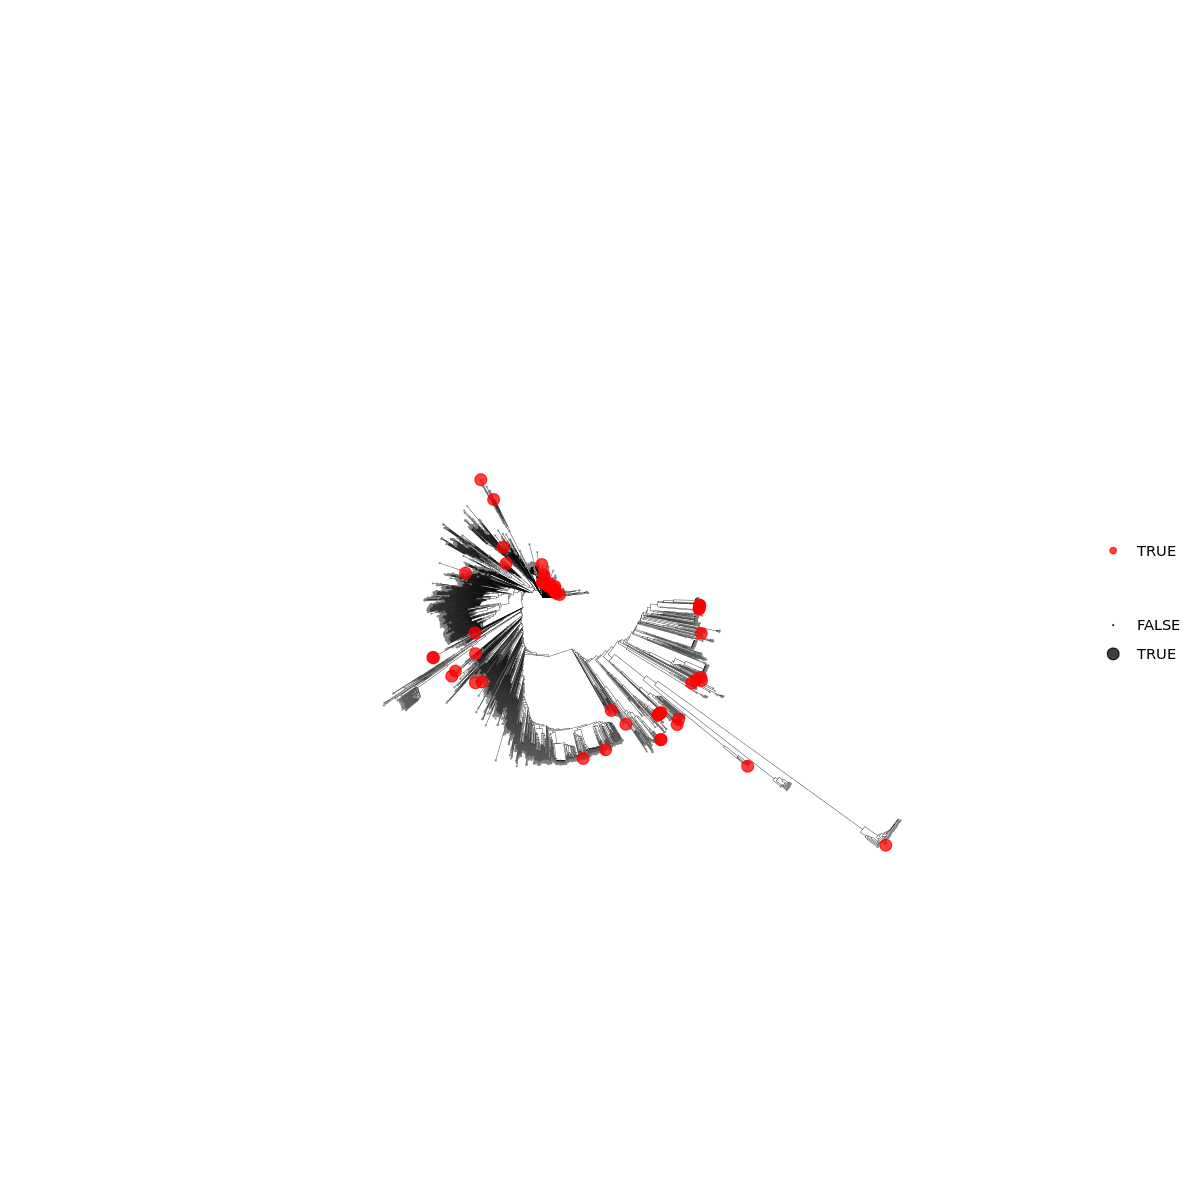

In [5]:
# quick and dirty overview plot used in presentations

all_strains_used<-unique(c(crosses_xlsx$`Short name 1`,crosses_xlsx$`Short name 2`))

sum(tr$tip.label %in% all_strains_used)==length(all_strains_used)

used_strains_in_tree<-c(tr$tip.label %in% all_strains_used,rep(NA,4976-2489))

library(ggtree)
options(repr.plot.width=10, repr.plot.height=10)
ggtree::ggtree(tr, layout="circular", size=0.1)+
geom_tippoint(aes(color=used_strains_in_tree,
                 size=used_strains_in_tree), alpha=.75)+
scale_color_manual(values=c("TRUE"="red"))+
scale_size_manual(values=c("TRUE"=3,"FALSE"=0,"NA"=0))+labs(size=NULL,color=NULL)

In [6]:
# here we generate the X random loci that we will compare to the focal TRD loci to get distributions

rng_file<-"/home/jnrunge/data/trd/local_phylogenies_random_data/rng.csv.gz"

chrpos<-data.table(chr=read.gdsn(index.gdsn(genofile, "snp.chromosome")), pos=read.gdsn(index.gdsn(genofile, "snp.position")))

closest_value <- function(vec, x) {
  vec[which.min(abs(vec - x))]
}


get_position=function(chrpos,x, size=50000){
    starting_point<-x
    # widen the window to size/2 on in both directions
    row_used<-slice(chrpos, starting_point)
    chr_subset<-filter(chrpos, chr==pull(row_used, chr))
    
    to_pos<-pull(row_used, pos)+(size/2)
    from_pos<-pull(row_used, pos)-(size/2)
    
    
    to_pos<-closest_value(pull(chr_subset, pos), to_pos)
    from_pos<-closest_value(pull(chr_subset, pos), from_pos)
    
    size_real<-to_pos-from_pos
    
    if(size_real<size & to_pos == max(pull(chr_subset, pos))){
        from_pos<-from_pos-(size-size_real)
        from_pos<-closest_value(pull(chr_subset, pos), from_pos)
    }
    
    if(size_real<size & from_pos == min(pull(chr_subset, pos))){
        to_pos<-to_pos+(size-size_real)
        to_pos<-closest_value(pull(chr_subset, pos), to_pos)
    }
    
    return(data.table(chr=pull(row_used, chr), from=from_pos, to=to_pos))
    
}


if(!file.exists(rng_file)){
    # get a list of 1,000 random regions, each group should be 50kB
    set.seed(1337)
    rng<-sample(1:nrow(chrpos), 10000)
    rng<-bind_rows(lapply(rng, get_position, chrpos=chrpos, size=50000))
    rng_file_lock<-flock::lock(rng_file)
    fwrite(rng, rng_file)
    flock::unlock(rng_file_lock)
}else{
    rng<-fread(rng_file)
}


head(rng)

chr,from,to
<int>,<int>,<int>
5,451702,501706
8,510133,560131
12,1022666,1072666
10,522692,572690
7,875903,925901
10,194592,244592


In [7]:
# check if random loci data is already there
# to avoid recomputing the same data

local_phylogeny_output_files_prefix<-"/home/jnrunge/data/trd/local_phylogenies_random_data/local_phylogenies."
local_phylogeny_output_files_postfix<-".RDS"




rng_indizes_to_run<-1:nrow(rng)

rng_indizes_to_run<-rng_indizes_to_run[!file.exists(paste0(local_phylogeny_output_files_prefix,
                                               rng_indizes_to_run,
                                               local_phylogeny_output_files_postfix))]


head(rng_indizes_to_run)
tail(rng_indizes_to_run)

[1] 8454 8470 8491 8568 8637 8787

[1] 8491 8568 8637 8787 8818 8830

In [8]:
local_phylogeny_output_file<-"/home/jnrunge/data/trd/local_phylogenies.RDS"

In [10]:
# compute random loci data if needed
# this will take days (!)

# only do this if not still running

#The check for LP running files is broken if runs crashed.

if(length(rng_indizes_to_run)>0 & 
  length(list.files(path = dirname(local_phylogeny_output_file), pattern = ".runningLP$"))==0){
    jobname="LocalPhylogeny"
    initial_timedate=Sys.time()
    scripts_dir<-"/home/jnrunge/data/trd/scripts"


    for(i in rng_indizes_to_run){
        cmd <- paste0("Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r ", rng_file, " ", i)

        print(cmd)
        
        file.create(running_file<-paste0(local_phylogeny_output_file,"_",i,".runningLP"))

        sbatch_list=execute_complex_sbatch(c(cmd,paste0("rm -f ",running_file)), jobname = jobname, scripts_dir = scripts_dir, uniqueRunID = i, cores="1", mem="4G", time="short", env="JupyteR4", initial_timedate = initial_timedate, jobs_simul = 20, jobs_total = 30)

       
    }

    if(exists("sbatch_list") &  jobname == "LocalPhylogeny"){
        print(sbatch_list)
        start_sbatch_list(sbatch_list, 20, jobname, initial_timedate)
    }

    while(length(list.files(path = dirname(local_phylogeny_output_file), pattern = ".runningLP$"))>0){
        Sys.sleep(60)
    }
    }

[1] "Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r /home/jnrunge/data/trd/local_phylogenies_random_data/rng.csv.gz 8454"
[1] "/home/jnrunge/data/trd/scripts/LocalPhylogeny-8454.sbatch"
[1] "Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r /home/jnrunge/data/trd/local_phylogenies_random_data/rng.csv.gz 8470"
[1] "/home/jnrunge/data/trd/scripts/LocalPhylogeny-8470.sbatch"
[1] "Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r /home/jnrunge/data/trd/local_phylogenies_random_data/rng.csv.gz 8491"
[1] "/home/jnrunge/data/trd/scripts/LocalPhylogeny-8491.sbatch"
[1] "Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r /home/jnrunge/data/trd/local_phylogenies_random_data/rng.csv.gz 8568"
[1] "/home/jnrunge/data/trd/scripts/LocalPhylogeny-8568.sbatch"
[1] "Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Create_Data_At_One_Locus.r /home/jnrunge/data/trd/local_phylogenies_random_d

In [11]:
# read in the random data

done_files<-list.files(path=dirname(local_phylogeny_output_files_prefix),pattern=paste0(basename(local_phylogeny_output_files_prefix),
                                                                           "[0-9]*",
                                                                           local_phylogeny_output_files_postfix),full.names = TRUE)
done_files<-done_files[file.size(done_files)>0]


#list_of_rds <- lapply(done_files, readRDS)

#merged_list <- purrr::reduce(list_of_rds, rbind)

local_phylogeny_data<-readRDS(done_files[1])
names(local_phylogeny_data)
for(f in done_files[-1]){
    tmp<-readRDS(f)
    
    for(n in names(tmp)){
        local_phylogeny_data[[n]][names(tmp[[n]])]<-tmp[[n]][names(tmp[[n]])]
    }
}

[1] "PCA_distances_from_0"     "IBS_MDS_distances_from_0"
[3] "rng_trees"

In [12]:
tree_distances_file<-paste0(dirname(local_phylogeny_output_files_prefix),
                              "/tree_distances.RDS")
tree_distances_need_computation<-FALSE

if(!file.exists(tree_distances_file)){
    tree_distances_need_computation<-TRUE
}else if(sum(file.mtime(tree_distances_file)<file.mtime(done_files))>0){
    tree_distances_need_computation<-TRUE
}
if(tree_distances_need_computation){
    file.create(paste0(tree_distances_file,".running"))
    cmd<-"Rscript ~/TRD/03_GenomicSignals/02_Local_Phylogeny_Compute_Random_Tree_Distances.r"
    cmd<-paste0(cmd, " && ",
          paste0("rm -f ",tree_distances_file,".running"))
    execute_cmd_sbatch(cmd, mem="8G", cpu="1", time="long", env="JupyteR4", jobname="LP_Random_Tree_Distances")
    
         while(file.exists(paste0(tree_distances_file,".running"))){
        Sys.sleep(60)
    }
    }

    
   



In [13]:
tree_distances_file_lock<-flock::lock(tree_distances_file)
tree_distances<-readRDS(tree_distances_file)
flock::unlock(tree_distances_file_lock)

In [14]:
# per trd region, I need focal IDs (numeric in the computed data) and chr,from,to.
# then I calculate the values for that region and compare them to the random regions

# load crosses
crosses_xlsx=readxl::read_xlsx("~/data/trd/Crosses.xlsx", sheet=2)
cc=data.frame("Cross ID"=c(paste0("ChrisC",1:8)),
                                  "Short name 1"=c("ACP","BAP","CCD","ATE","ACK","AKE","BAH","ANG"),
                                  "Short name 2"=c("BFP","CMP","CPG","SACE_YCR","ACV","BAH","CGD","CEI"), stringsAsFactors=FALSE)
colnames(cc)=str_replace_all(colnames(cc), fixed("."), " ")
crosses_xlsx <- bind_rows(crosses_xlsx[,c("Cross ID","Short name 1","Short name 2")],
                        cc)


# load all TRD regions
TRD_regions<-fread_and_bind_files(list.files("/home/jnrunge/data/TRD/results/shiny/",pattern="TRD_regions.csv.gz$",full.names = TRUE))
TRD_regions<-mutate(TRD_regions, file=basename(file))%>%separate(file, c("cross","discard"), "-")%>%select(-discard)%>%filter(chr_start==chr_end)%>%
rename(chr=chr_start)%>%select(-chr_end)

# translate global positions to chr positions

for(c in select(TRD_regions,cross)%>%distinct()%>%pull())
    {
    AF<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    tmp_TRD_regions<-filter(TRD_regions, cross==c)%>%select(-any_of("start"))%>%
              left_join(select(AF, chr,pos,global_pos)%>%
              rename(global_start=global_pos), by=c("chr","global_start"))%>%rename(start=pos)
    
    TRD_regions<-filter(TRD_regions, cross!=c)%>%bind_rows(tmp_TRD_regions)
}

TRD_regions<-mutate(TRD_regions, end=global_end-(global_start-start))

head(TRD_regions)

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250


In [15]:
TRD_regions<-mutate(TRD_regions, 
                   PCA_eucldist_quantile_1=NA,
                   PCA_eucldist_sd_multiplier_1=NA,
                   IBS_eucldist_quantile_1=NA,
                   IBS_eucldist_sd_multiplier_1=NA,
                    
                   tree_changes_quantile=NA,
                   tree_changes_sd_multiplier=NA,
                   tree_changes_raw=NA,
                   
                   PCA_eucldist_quantile_2=NA,
                   PCA_eucldist_sd_multiplier_2=NA,
                   IBS_eucldist_quantile_2=NA,
                   IBS_eucldist_sd_multiplier_2=NA)

In [26]:
euclidean_distance <- function(x, y) {
  sqrt(x^2 + y^2)
}
# Define a function to perform your calculations and plot
calculate_and_plot <- function(distances_key, trd_region, plot_name, TRD_regions_slice) {
  sd_multi <- c()
  quant <- c()
  
  for(id in ids) {
    distances_from_0_id <- purrr::map(local_phylogeny_data[[distances_key]], id) %>% unlist()
    
    # Compute mean and sd of your data
    mean_dist <- mean(distances_from_0_id, na.rm = TRUE)
    sd_dist <- sd(distances_from_0_id, na.rm = TRUE)
    
    # Plot histogram, vertical line and normal distribution
    print(
      p<-ggplot(data.frame(distances_from_0_id = distances_from_0_id), aes(x = distances_from_0_id)) +
        geom_histogram(aes(y = after_stat(density)), bins = 30) +
        geom_vline(xintercept = trd_region[id], color = "red") +
        stat_function(
          fun = dnorm, 
          args = list(mean = mean_dist, sd = sd_dist), 
          color = "blue"
        )+theme_bw(base_size=18)+xlab("Eucl. distance from 0")+ylab(NULL)+ggtitle(paste0(plot_name, " Cross ",pull(TRD_regions_slice, cross), " TRD ", pull(TRD_regions_slice, ID), "  Strain ",read.gdsn(index.gdsn(genofile, "sample.id"))[id]))
    )
      
    saveRDS(p, paste0(output_dir,"/",pull(TRD_regions_slice, cross),".",pull(TRD_regions_slice, ID),".",read.gdsn(index.gdsn(genofile, "sample.id"))[id],".",
                     plot_name,".RDS"))
    
    sd_multi <- c(sd_multi, (trd_region[id] - mean_dist) / sd_dist)
    quant <- c(quant, ecdf(distances_from_0_id)(trd_region[id]))
  }
  
  return(list(sd_multi, quant))
}

# Define a function to mutate your dataframe
mutate_TRD_regions <- function(TRD_regions, cross, sd_multi, quant, prefix, TRD_regions_slice) {
    
    if(length(sd_multi)==2){
        TRD_regions <- TRD_regions %>%
    mutate(
      !!paste0(prefix, "_quantile_1") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                          quant[1], get(paste0(prefix, "_quantile_1"))),
      !!paste0(prefix, "_sd_multiplier_1") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                              sd_multi[1], get(paste0(prefix, "_sd_multiplier_1"))),
      !!paste0(prefix, "_quantile_2") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                          quant[2], get(paste0(prefix, "_quantile_2"))),
      !!paste0(prefix, "_sd_multiplier_2") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                              sd_multi[2], get(paste0(prefix, "_sd_multiplier_2")))
    )
    }else if(length(sd_multi)==1){
        TRD_regions <- TRD_regions %>%
    mutate(
      !!paste0(prefix, "_quantile") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                          quant, get(paste0(prefix, "_quantile"))),
      !!paste0(prefix, "_sd_multiplier") := ifelse(cross == pull(TRD_regions_slice, cross) & ID == pull(TRD_regions_slice, ID),
                                                              sd_multi, get(paste0(prefix, "_sd_multiplier")))
    )
    }
  
  
  return(TRD_regions)
}
plot_pca_data <- function(genofile, ids, x_pca_trd, y_pca_trd,name_for_plot, TRD_regions_slice) {
  df <- tibble(id = as.character(1:length(read.gdsn(index.gdsn(genofile, "sample.id")))),
               x_pca_trd = x_pca_trd,
               y_pca_trd = y_pca_trd,
               is_in = id %in% as.numeric(ids)) %>%
    mutate(
      x_arrow_start = ifelse(is_in, x_pca_trd + (0.10 * diff(range(x_pca_trd))), NA),
      y_arrow_start = ifelse(is_in, y_pca_trd + (0.10 * diff(range(y_pca_trd))), NA),
      arrow_color = case_when(
        id == ids[1] ~ "blue",
        is_in ~ "red",
        TRUE ~ NA_character_
      )
    )

plot_pca <- ggplot(df, aes(x_pca_trd, y_pca_trd)) +
    geom_point(shape = 1) +
    geom_segment(data = df %>% filter(is_in),
                 aes(x = x_arrow_start, y = y_arrow_start, xend = x_pca_trd, yend = y_pca_trd, color = arrow_color),
                 arrow = arrow(length = unit(0.05, "npc"))) +
    scale_color_manual(values = c("blue", "red"), 
                       labels = c(read.gdsn(index.gdsn(genofile, "sample.id"))[ids[1]], read.gdsn(index.gdsn(genofile, "sample.id"))[ids[2]]),
                       guide = guide_legend(title = NULL)) +
    theme_bw(base_size=18)+
    xlab("Dim 1")+ylab("Dim 2")+ggtitle(name_for_plot)+
    theme(legend.position="bottom")

    
    print(plot_pca)
    
    saveRDS(plot_pca, paste0(output_dir,"/",pull(TRD_regions_slice, cross),".",pull(TRD_regions_slice, ID),".",
                     name_for_plot,".RDS"))
    
    
}

In [19]:
# is the LP results file newer than 
# all TRD region files
# all random LP files

if(file.exists(paste0(output_dir,"/","TRD_regions_with_LP_data.csv.gz"))){
    if(file.mtime(paste0(output_dir,"/","TRD_regions_with_LP_data.csv.gz"))>max(file.mtime(c(list.files("/home/jnrunge/data/TRD/results/shiny/",pattern="TRD_regions.csv.gz$",full.names = TRUE),list.files("~/data/trd/local_phylogenies_random_data/",full.names=TRUE))))){
        TRD_regions<-fread(paste0(output_dir,"/","TRD_regions_with_LP_data.csv.gz"))
    }
    
}

In [20]:
head(TRD_regions)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] 1
Principal Component Analysis (PCA) on genotypes:
Excluding 2,193,775 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 22,425
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 108818935
CPU capabilities: Double-Precision SSE2
Tue Jul 11 17:51:41 2023    (internal increment: 2616)
[==================================================] 100%, completed, 31s 
Tue Jul 11 17:52:12 2023    Begin (eigenvalues and eigenvectors)
Tue Jul 11 17:52:16 2023    Done.
Identity-By-State (IBS) analysis on genotypes:
Excluding 2,193,775 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 22,425
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 108818935
Tue Jul 11 17:52:17 2023    (internal increment: 65536)
[======================================

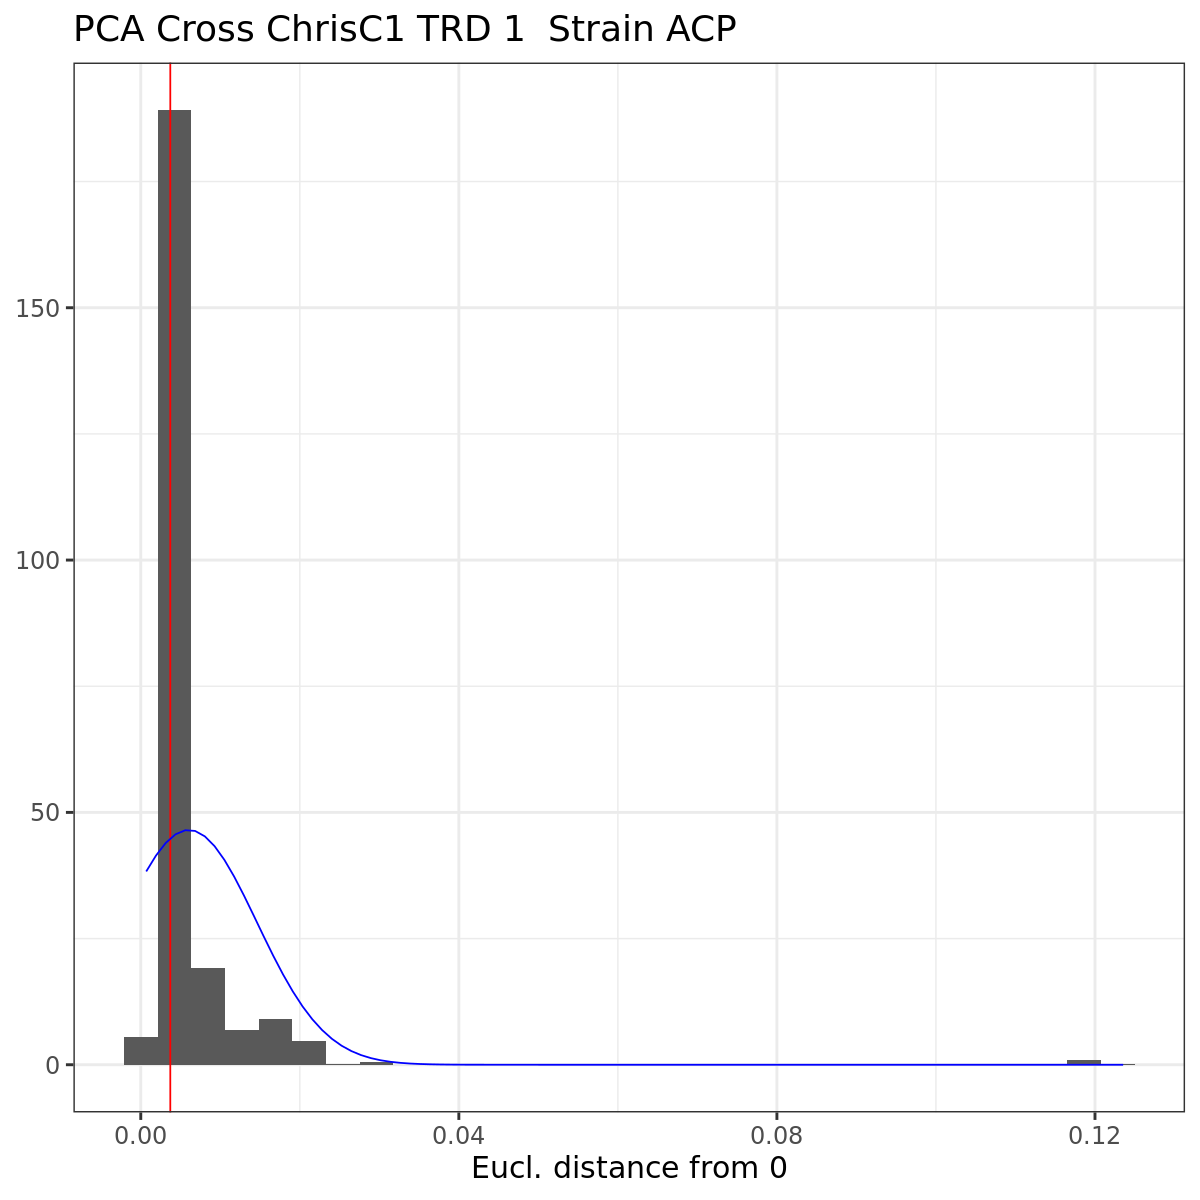

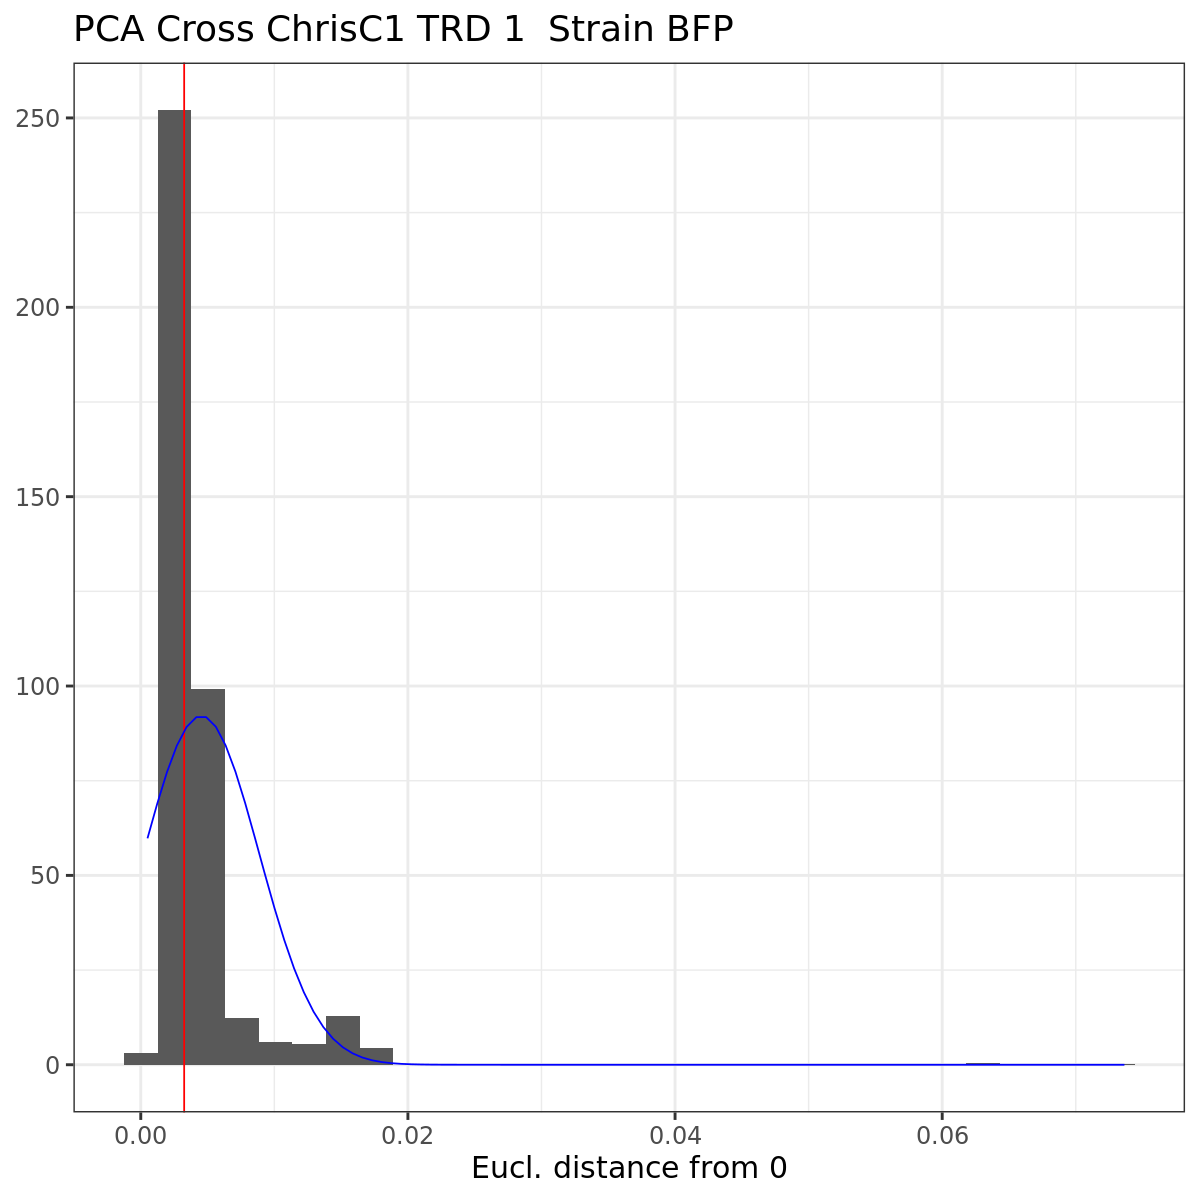

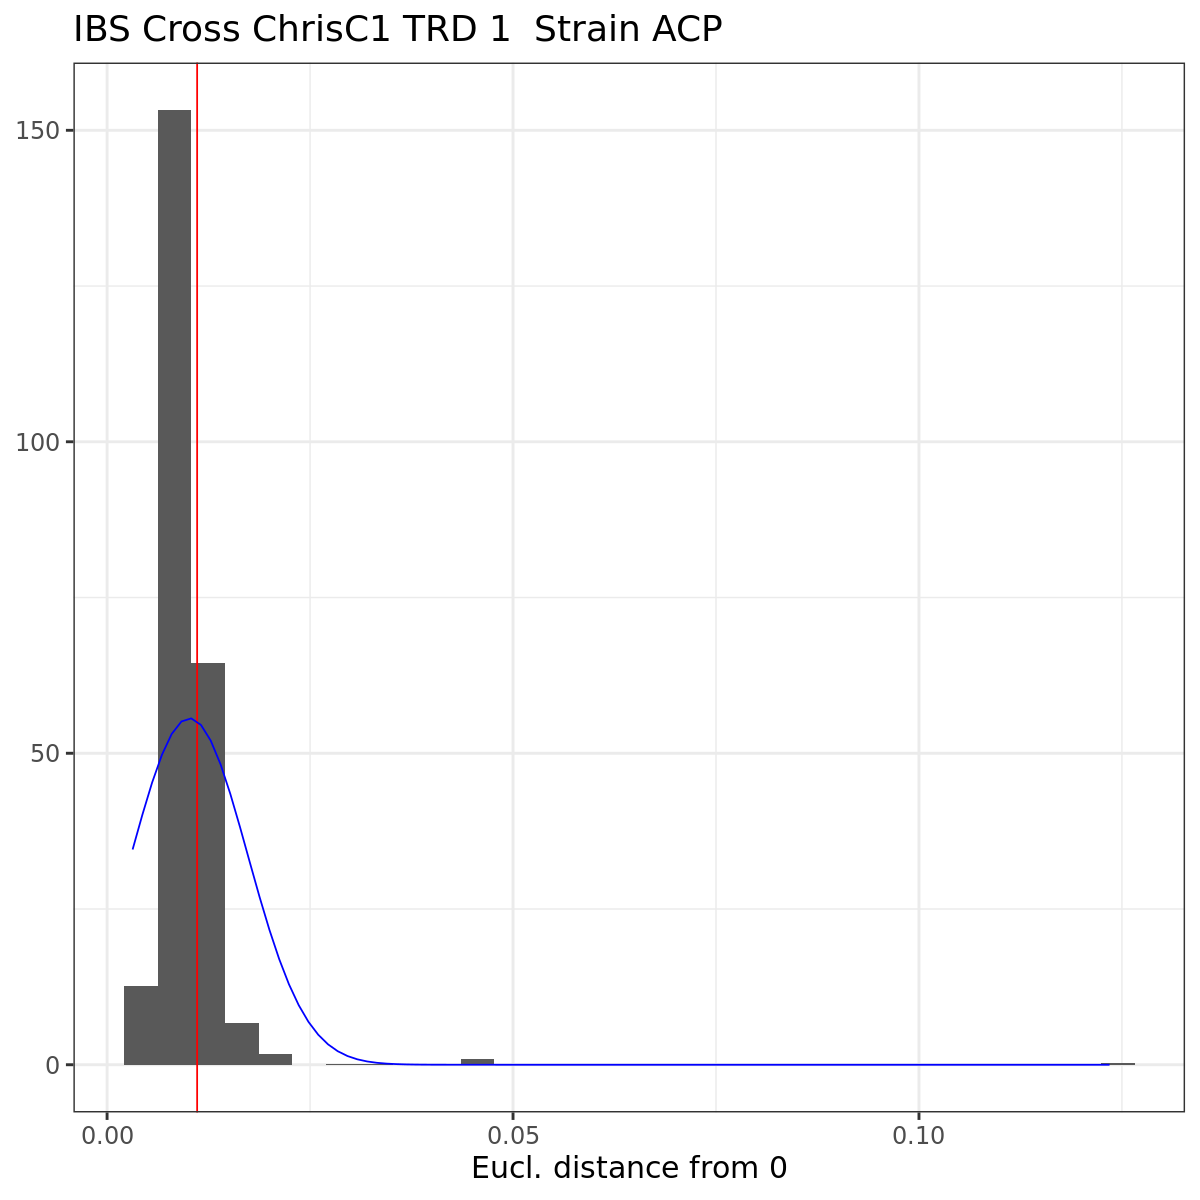

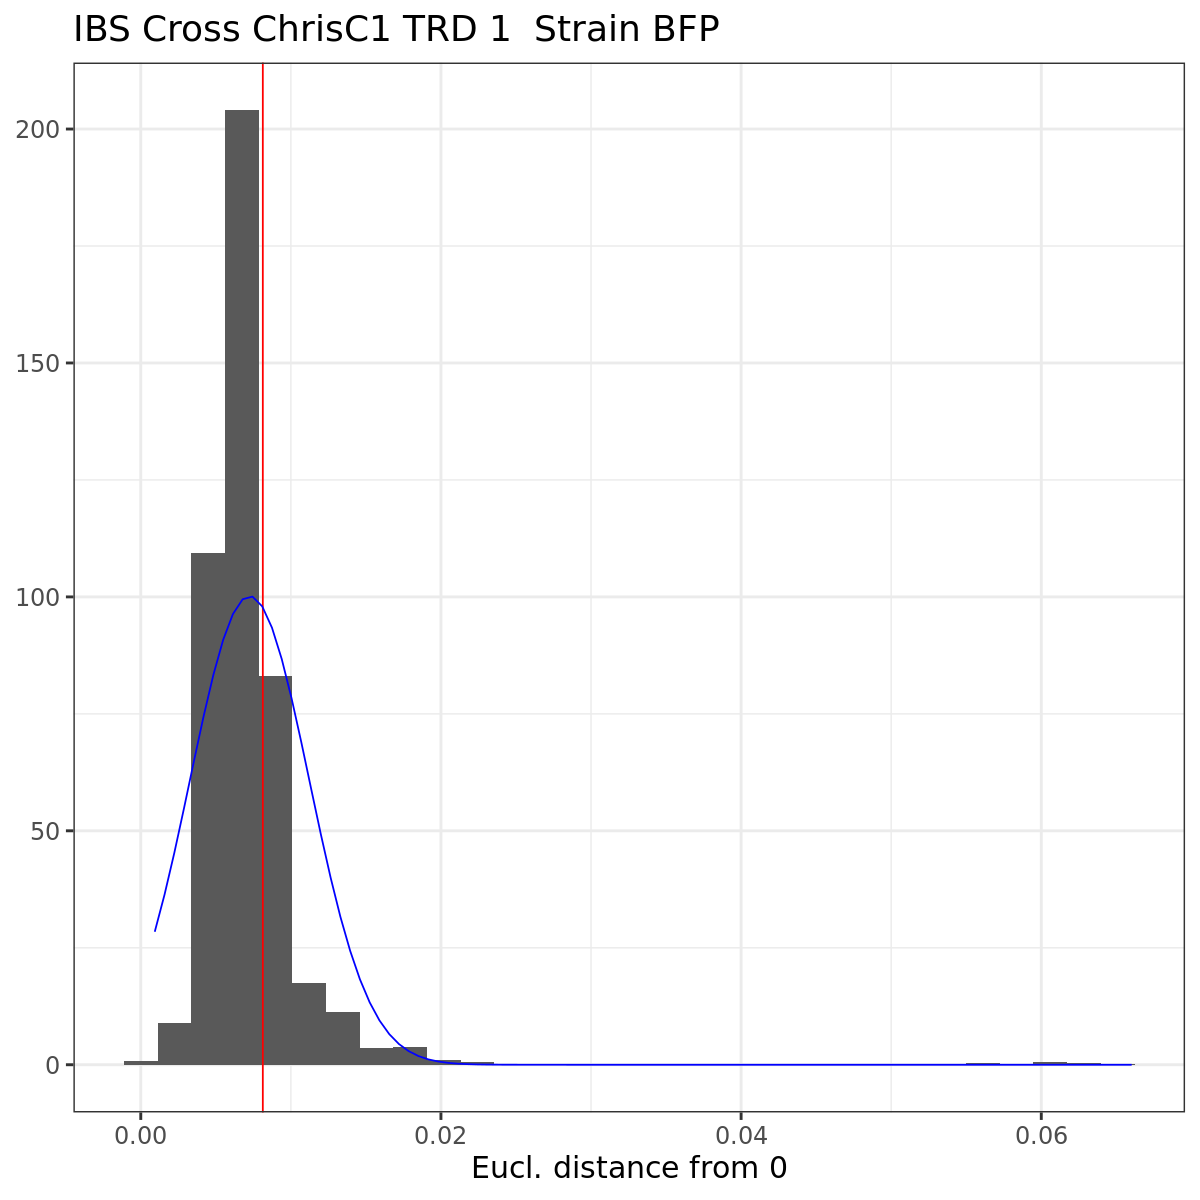

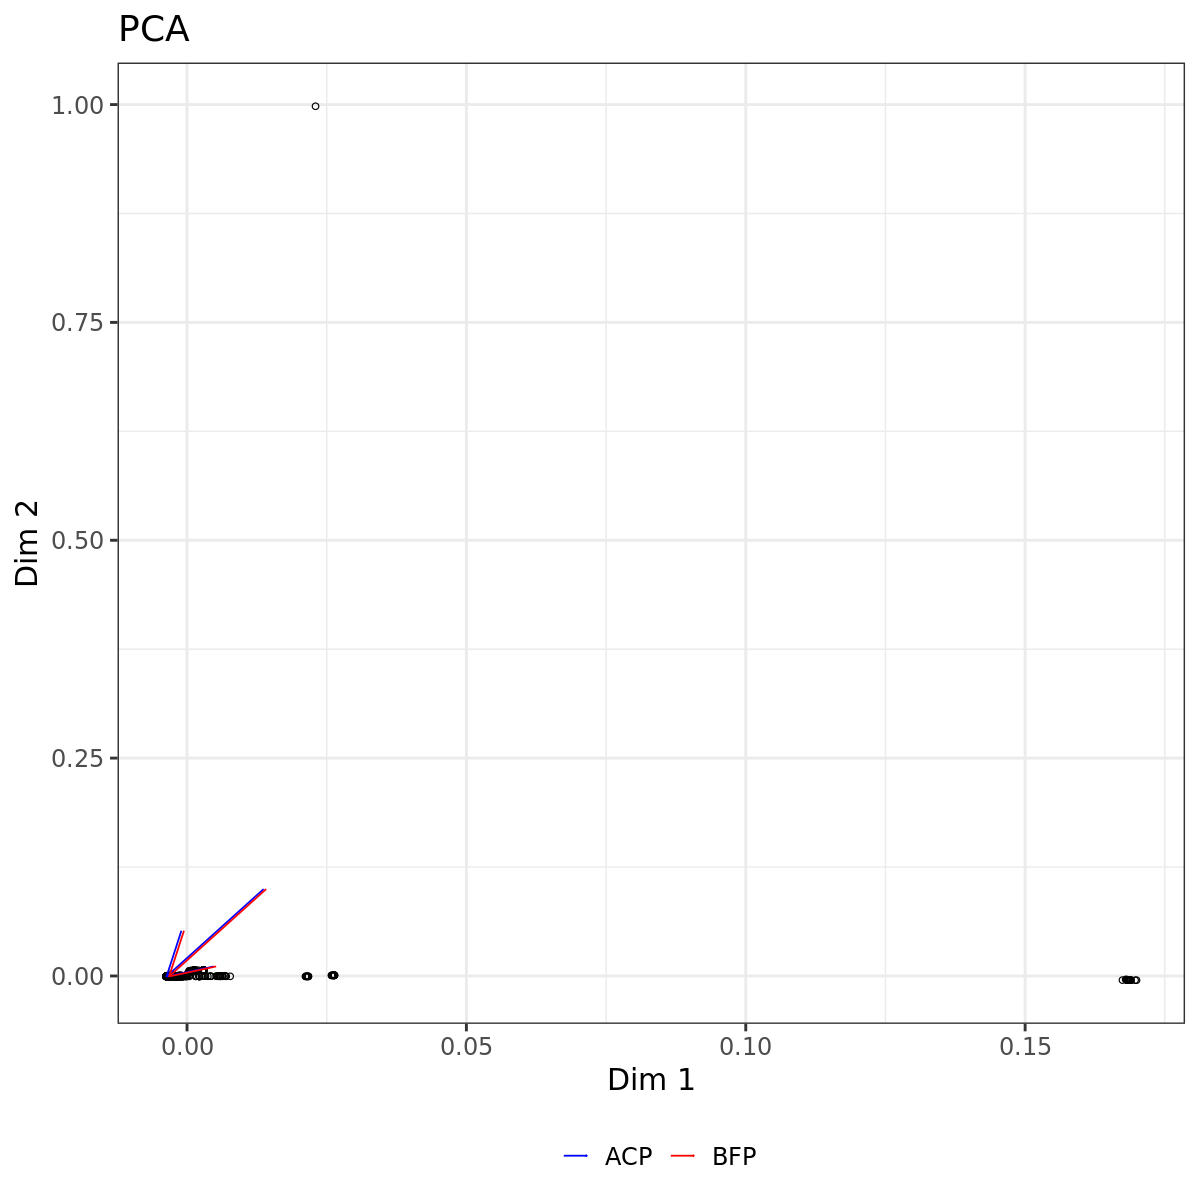

[1] 2
Principal Component Analysis (PCA) on genotypes:
Excluding 2,178,552 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 37,648
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 184271965
CPU capabilities: Double-Precision SSE2
Tue Jul 11 17:59:23 2023    (internal increment: 2616)
[==================================================] 100%, completed, 47s 
Tue Jul 11 18:00:10 2023    Begin (eigenvalues and eigenvectors)
Tue Jul 11 18:00:14 2023    Done.
Identity-By-State (IBS) analysis on genotypes:
Excluding 2,178,552 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 37,648
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 184271965
Tue Jul 11 18:00:14 2023    (internal increment: 65536)
[======================================

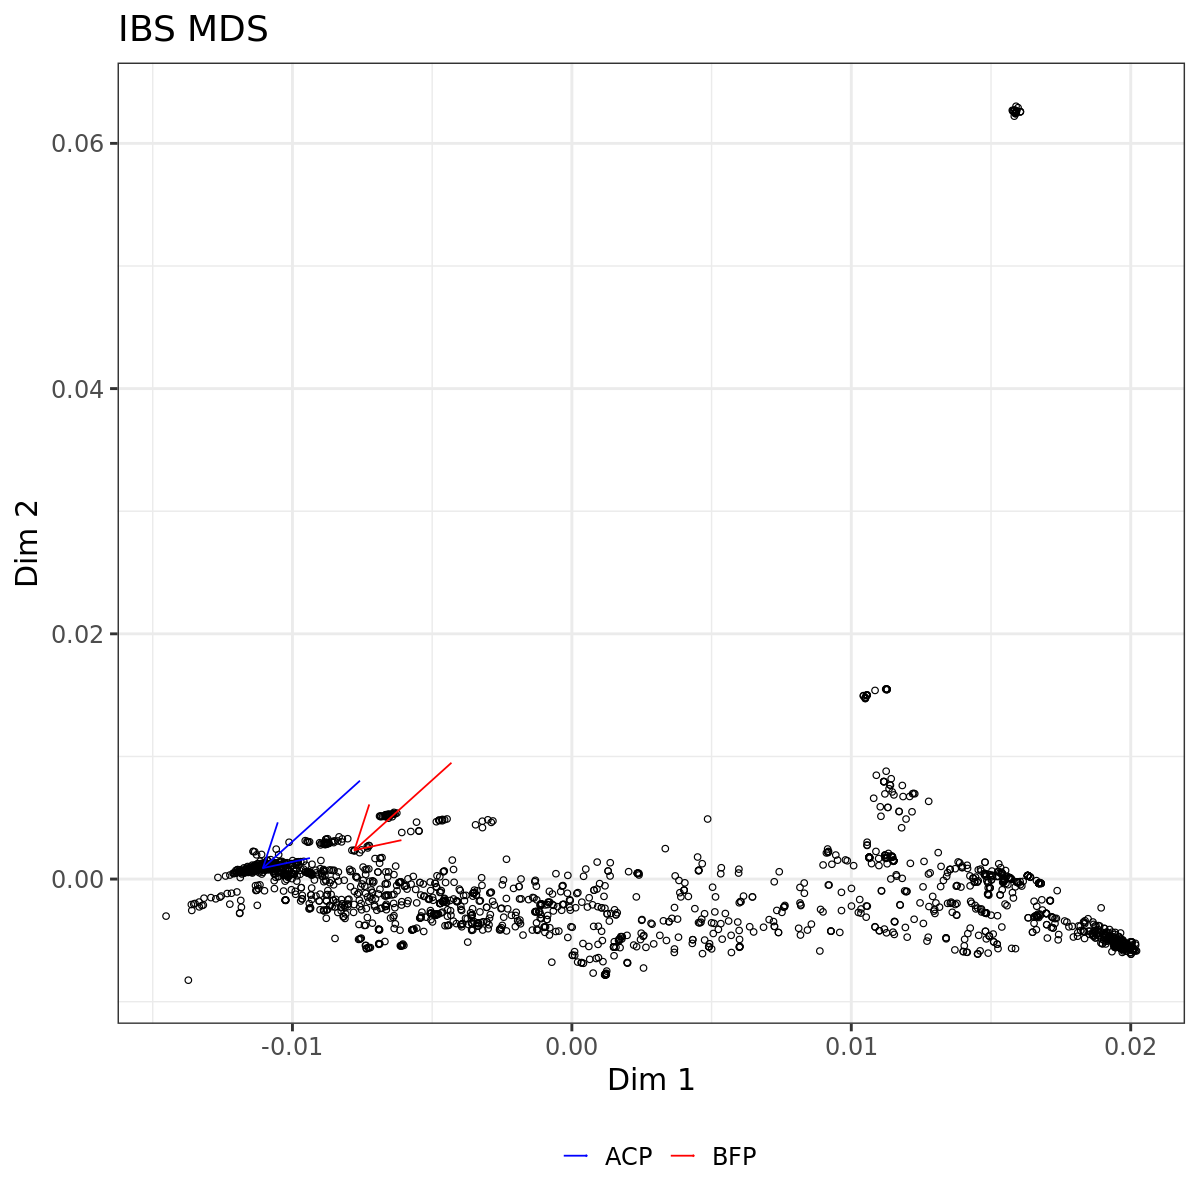

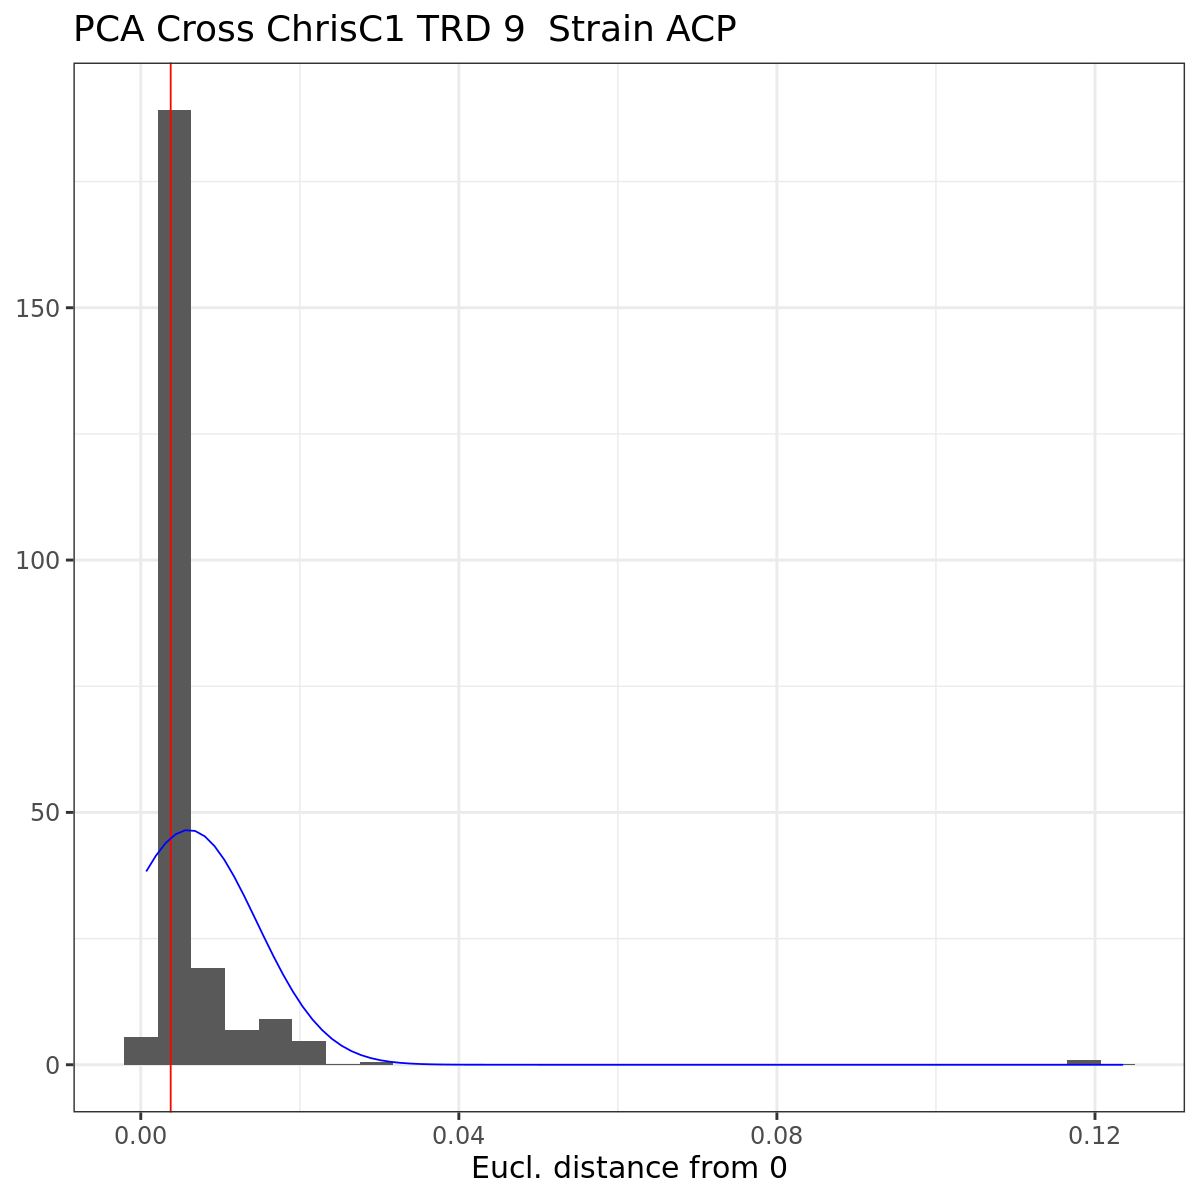

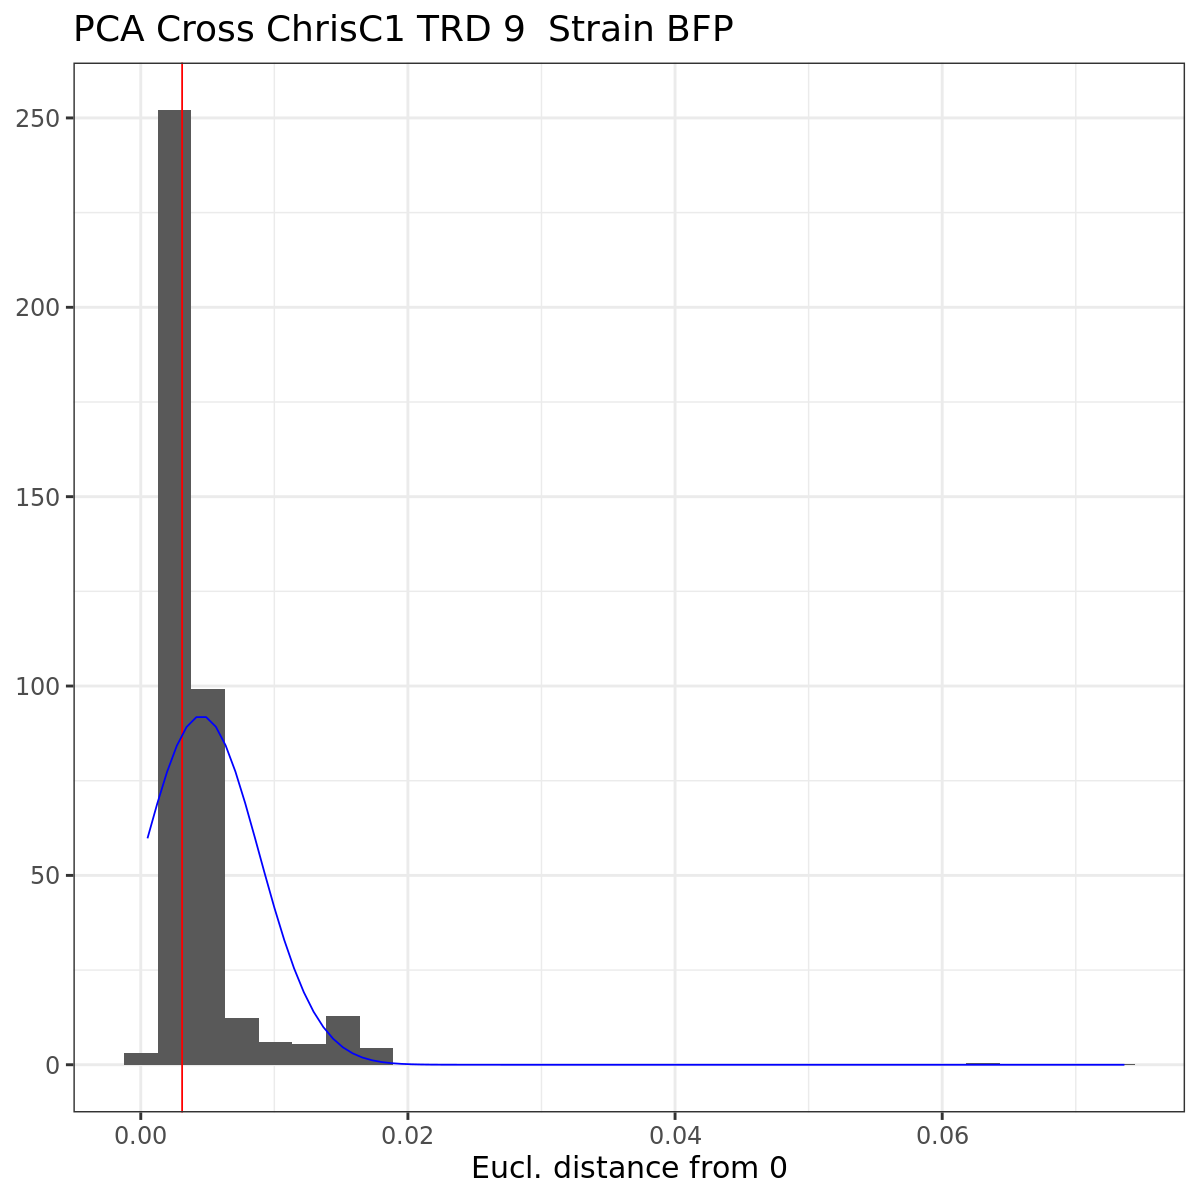

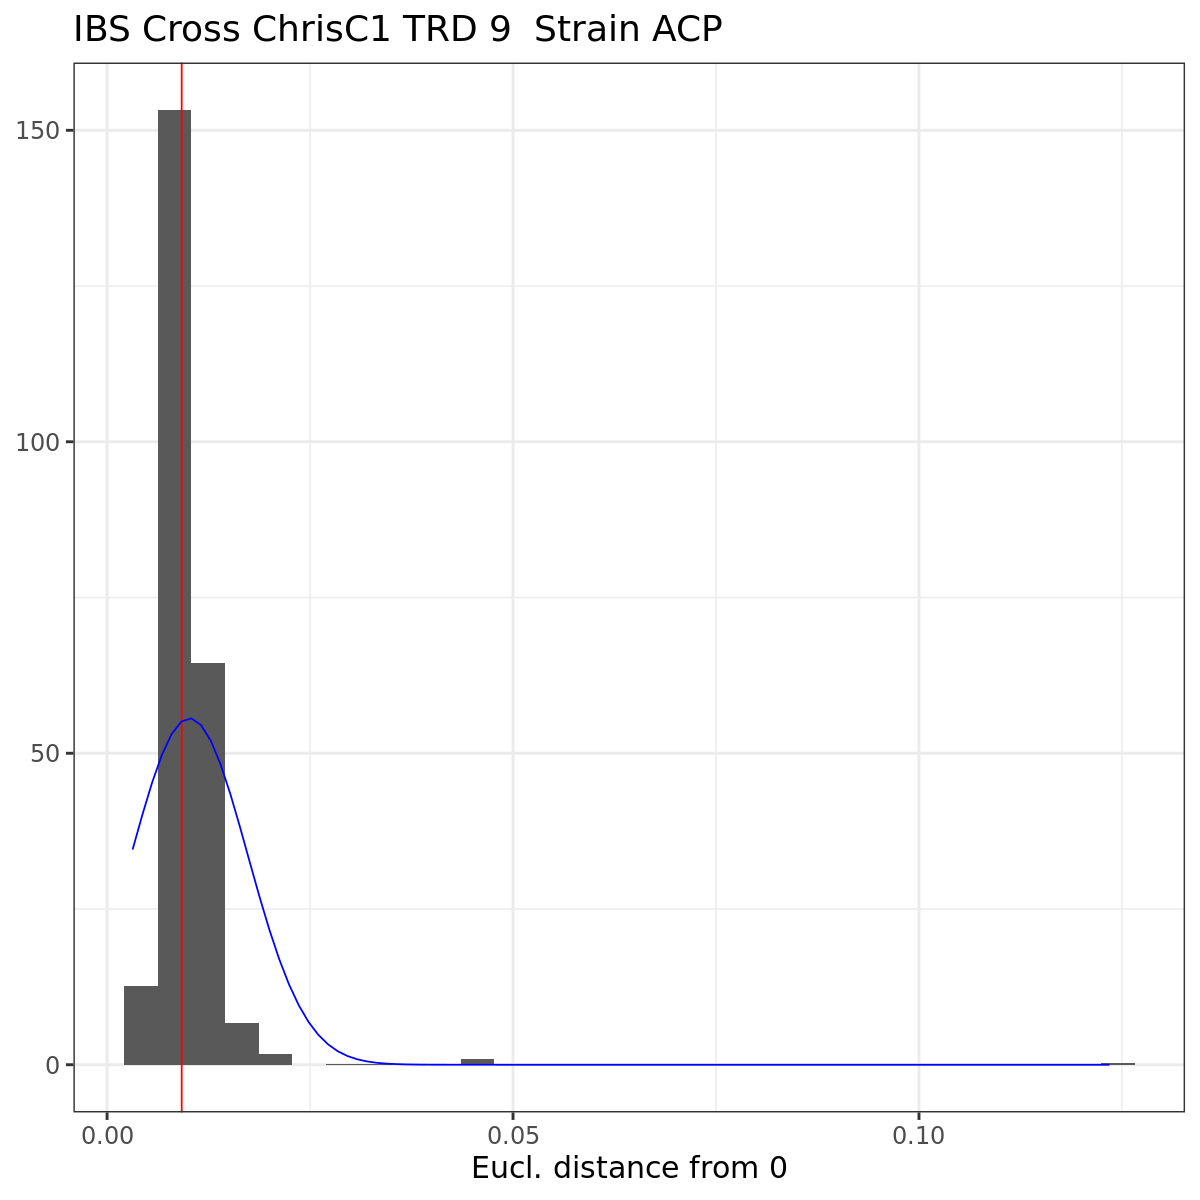

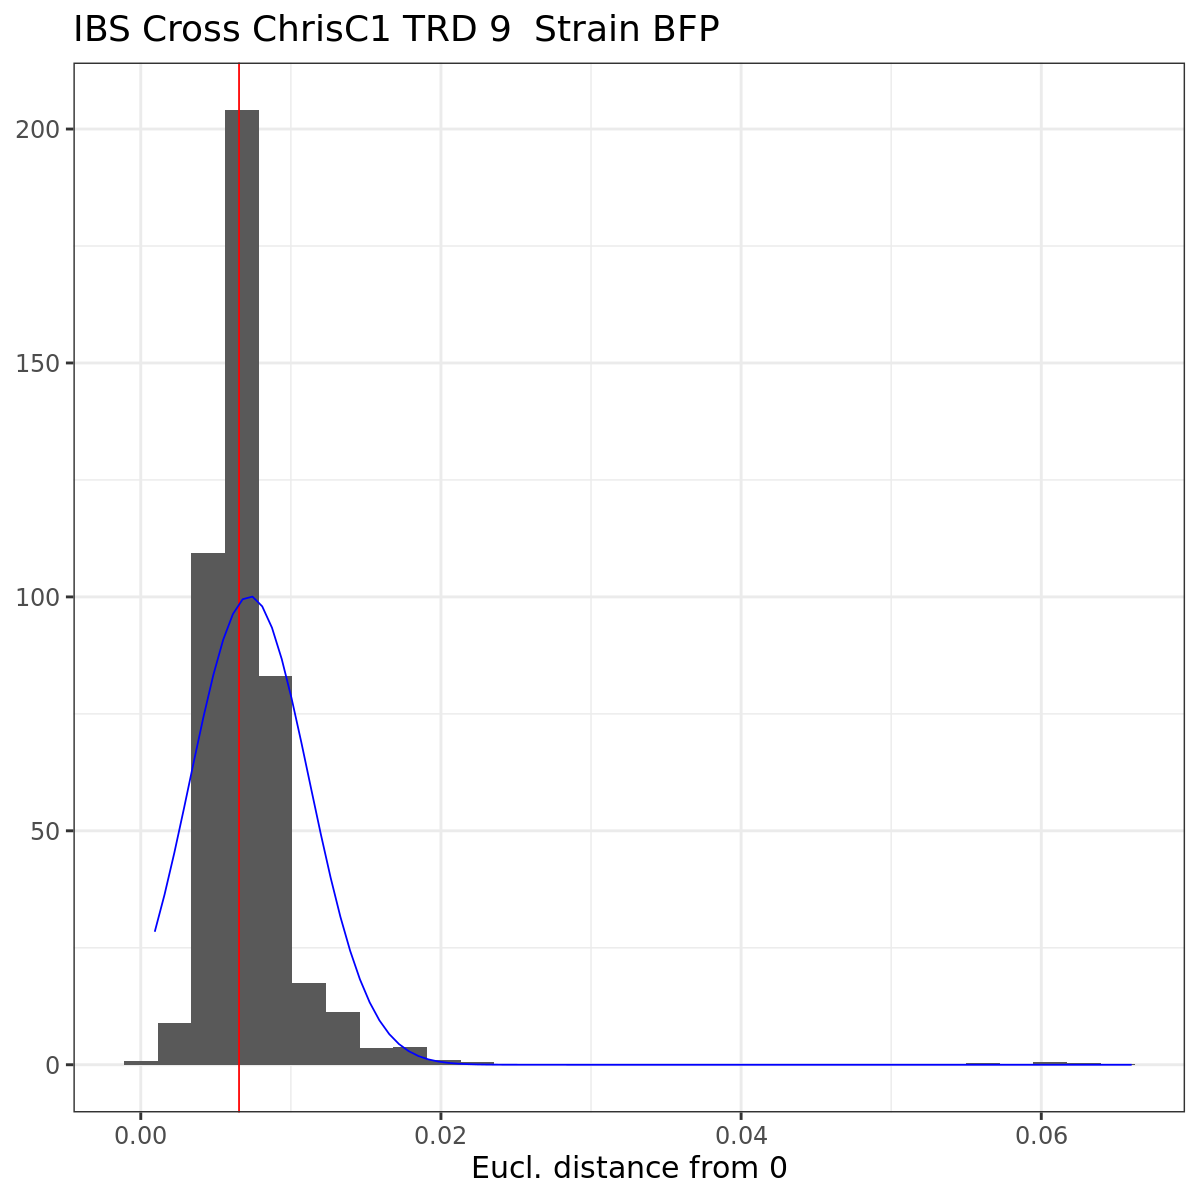

In [ ]:
for(i in 1:nrow(TRD_regions)){
    
    print(i)
    



    # get the ids of the cross in numeric format

    TRD_regions_slice<-slice(TRD_regions, i)
    
    if(!is.na(pull(TRD_regions_slice,tree_changes_sd_multiplier))){
        next
    }
    
    crosses_xlsx_slice<-filter(crosses_xlsx, `Cross ID` == pull(TRD_regions_slice, cross))

    ids<-which(read.gdsn(index.gdsn(genofile, "sample.id")) %in% c(pull(crosses_xlsx_slice,`Short name 1`), pull(crosses_xlsx_slice, `Short name 2`)))
    ids

    # compute values for the TRD region

    snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))>=pull(TRD_regions_slice,start)&
                     read.gdsn(index.gdsn(genofile, "snp.position"))<=pull(TRD_regions_slice,end)&
                     read.gdsn(index.gdsn(genofile, "snp.chromosome"))==pull(TRD_regions_slice,chr)%>%str_replace("chromosome",""))
    if(length(snpset)==0){
        next
    }

    pca_trd <- snpgdsPCA(genofile, num.thread=1, snp.id = snpset)

        x_pca_trd<-pca_trd$eigenvect[,1]
        y_pca_trd<-pca_trd$eigenvect[,2]

    PCA_distances_from_0_trd<-euclidean_distance(x_pca_trd,y_pca_trd)

    ibs_trd <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
        loc <- cmdscale(1 - ibs_trd$ibs, k = 2)

        x_ibs_trd <- loc[, 1]
        y_ibs_trd <- loc[, 2]

    IBS_MDS_distances_from_0_trd<-euclidean_distance(x_ibs_trd,y_ibs_trd)


    dissMatrix_trd <- snpgdsDiss(genofile, snp.id=snpset, num.thread = 1)
        colnames(dissMatrix_trd$diss) <- dissMatrix_trd$sample.id
        tree_trd <- bionjs(dissMatrix_trd$diss)

    # Call your functions for each of your scenarios
    PCA_results <- calculate_and_plot("PCA_distances_from_0", PCA_distances_from_0_trd, "PCA", TRD_regions_slice)
    TRD_regions <- mutate_TRD_regions(TRD_regions, cross, PCA_results[[1]], PCA_results[[2]], "PCA_eucldist", TRD_regions_slice)

    IBS_results <- calculate_and_plot("IBS_MDS_distances_from_0", IBS_MDS_distances_from_0_trd, "IBS", TRD_regions_slice)
    TRD_regions <- mutate_TRD_regions(TRD_regions, cross, IBS_results[[1]], IBS_results[[2]], "IBS_eucldist", TRD_regions_slice)




    plot_pca_data(genofile, ids, x_pca_trd, y_pca_trd, "PCA", TRD_regions_slice)

    plot_pca_data(genofile, ids, x_ibs_trd, y_ibs_trd, "IBS MDS", TRD_regions_slice)


    trd_region <- dist.topo(tr, tree_trd, method = "score")

    # Compute mean and sd of your data
    mean_dist <- mean(tree_distances, na.rm = TRUE)
    sd_dist <- sd(tree_distances, na.rm = TRUE)

    # Plot histogram, vertical line and normal distribution
    p<-ggplot(data.frame(tree_distances = tree_distances), aes(x = tree_distances)) +
      geom_histogram(aes(y = after_stat(density)), bins = 30) +
      geom_vline(xintercept = trd_region, color = "red") +
      stat_function(
        fun = dnorm, 
        args = list(mean = mean_dist, sd = sd_dist), 
        color = "blue"
      )+theme_bw(base_size=18)+xlab("Topological distance (w/ branch lengths) between local and global phylogeny")+ylab(NULL)+ggtitle("")
    
    saveRDS(p, paste0(output_dir,"/",pull(TRD_regions_slice, cross),".",pull(TRD_regions_slice, ID),".",
                     "tree_distances",".RDS"))


    TRD_regions <- mutate_TRD_regions(TRD_regions, cross, (trd_region - mean_dist) / sd_dist, ecdf(tree_distances)(trd_region), "tree_changes", TRD_regions_slice)
    
    TRD_regions <- mutate(TRD_regions, tree_changes_raw=ifelse(ID==pull(TRD_regions_slice, ID) & 
                                                               cross==pull(TRD_regions_slice, cross),trd_region,tree_changes_raw))
    
    }

In [ ]:
fwrite(TRD_regions, paste0(output_dir,"/","TRD_regions_with_LP_data.csv.gz"))

# What to do with phylogeny data?

Instead of comparing distances between the crossed strains (what's the point) throughout the genome, it might be better to ask how do the X closest neighbors change in the TRD region vs throughout random points in the genome, for both crossed strains. This way we can ask how much more rearranged the tree is in that region.

We could look at the distance of the two strains, but its really slow

````bash

# for each region

ape::cophenetic.phylo(tr)
# into a list of distances

# then

id=1
id2=50
extract_coord <- function(mat,x,y) {
  mat[x, y]
}

rng_tree_distances_ids<-purrr::pmap(list(rng_tree_distances, id, id2), extract_coord)%>%unlist()
trd_region=rng_tree_distances[[300]] # this should be its own object, calculated just before

````

In [ ]:
stop("Below is outdated, but remains in case it is needed for now")

In [ ]:
crosses=readLines("~/data/trd/mapped_reads/TRD.vcf.gz.samples")
crosses=crosses[startsWith(crosses, "YJNRC") | startsWith(crosses, "Chris")]
crosses

In [ ]:
file_a_exists_and_is_newer_than_file_b=function(a,b){
    if(file.exists(a)){
        if(file.mtime(a)>file.mtime(b)){
            return(TRUE)
        }
    }
    return(FALSE)
}

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)



In [ ]:
crosses=c("ChrisC7")

In [ ]:
for(c in crosses){
    TRD_regions_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz")
    AS_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")
    TRD_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz")
    
        if(!file_a_exists_and_is_newer_than_file_b(TRD_file,"~/data/trd/mapped_reads/TRD.vcf.gz")){
        print(paste0(c, " TRD file does not exist or is not newer than TRD.vcf.gz"))
        next
    }
    
    if(!file_a_exists_and_is_newer_than_file_b(TRD_regions_file,TRD_file)){
        print(paste0(c, " has no TRD regions or no up-to-date ones"))
        next
    }
    if(!file_a_exists_and_is_newer_than_file_b(AS_file,TRD_file)){
        print(paste0(c, " has no or no updated allele sharing file"))
        next
    }
    p_global<-ggplot(tab_global, aes(EV2,EV1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c))
    print(p_global)
    
    p_ibs_global<-ggplot(tab_ibs_global, aes(MDS2,MDS1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c))
    print(p_ibs_global)
    
    AS=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))

    TRD=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))

    TRD_loci=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))

    for(i in 1:nrow(TRD_loci)){
        if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
            stop("chr overlapping TRD")
        }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)

        snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))%in%TRD_subset$pos & 
                     paste0("chromosome",read.gdsn(index.gdsn(genofile, "snp.chromosome"))) == TRD_loci$chr_start[i])

        pca_TRD <- snpgdsPCA(genofile, num.thread=1, snp.id = snpset)

        pca_TRD.percent <- pca_TRD$varprop*100

        tab <- data.frame(sample.id = pca_TRD$sample.id,
            EV1 = pca_TRD$eigenvect[,1],    # the first eigenvector
            EV2 = pca_TRD$eigenvect[,2],    # the second eigenvector
            stringsAsFactors = FALSE)

        p<-ggplot(tab, aes(EV2,EV1, color=sample.id=="ACI",size=sample.id=="ACI"))+
        geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c,i))
        print(p)
        
        
        
        
        
        
        ibs <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
loc <- cmdscale(1 - ibs$ibs, k = 2)
x <- loc[, 1]; y <- loc[, 2]

tab_ibs <- data.frame(sample.id = ibs$sample.id,
            MDS1 = x,    # the first eigenvector
            MDS2 = y,    # the second eigenvector
            stringsAsFactors = FALSE)


p_ibs<-ggplot(tab_ibs, aes(MDS2,MDS1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c,i))
        
        print(p_ibs)
        

    }

}